<img src="./images/DLI_Header.png" style="width: 400px;">

In [1]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [2]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
base_model.trainable = False

In [4]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [5]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


Keras gives us a nice summary here, as it shows the vgg16 pre-trained model as one unit, rather than showing all of the internal layers. It is also worth noting that we have many non-trainable parameters as we have frozen the pre-trained model. 

In [6]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True) # we don't expect Bo to be upside-down so we will not flip vertically

In [8]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('Train_E/', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('Valid_E/', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 122 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


Time to train our model and see how it does. Recall that when using a data generator, we have to explicitly set the number of `steps_per_epoch`:

In [9]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 31s 3s/step - loss: 1.0819 - binary_accuracy: 0.7396 - val_loss: 0.5628 - val_binary_accuracy: 0.8438
Epoch 2/20
12/12 [==============================] - 31s 3s/step - loss: 0.8888 - binary_accuracy: 0.7222 - val_loss: 0.8360 - val_binary_accuracy: 0.7812
Epoch 3/20
12/12 [==============================] - 32s 3s/step - loss: 0.4542 - binary_accuracy: 0.8556 - val_loss: 0.3465 - val_binary_accuracy: 0.9062
Epoch 4/20
12/12 [==============================] - 32s 3s/step - loss: 0.5287 - binary_accuracy: 0.7889 - val_loss: 0.4552 - val_binary_accuracy: 0.8438
Epoch 5/20
12/12 [==============================] - 33s 3s/step - loss: 0.3660 - binary_accuracy: 0.8646 - val_loss: 0.4932 - val_binary_accuracy: 0.9062
Epoch 6/20
12/12 [==============================] - 32s 3s/step - loss: 0.3740 - binary_accuracy: 0.8750 - val_loss: 0.9209 - val_binary_accuracy: 0.8750
Epoch 7/20
12/12 [==============================] - 32s 3s/step - loss: 0.36

## Fine-Tuning the Model

In [10]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [11]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 93s 8s/step - loss: 0.3397 - binary_accuracy: 0.9000 - val_loss: 0.2987 - val_binary_accuracy: 0.8125
Epoch 2/10
12/12 [==============================] - 100s 8s/step - loss: 0.2075 - binary_accuracy: 0.9444 - val_loss: 0.6406 - val_binary_accuracy: 0.8125
Epoch 3/10
12/12 [==============================] - 107s 9s/step - loss: 0.0794 - binary_accuracy: 0.9667 - val_loss: 0.2613 - val_binary_accuracy: 0.9062
Epoch 4/10
12/12 [==============================] - 100s 8s/step - loss: 0.0688 - binary_accuracy: 0.9667 - val_loss: 1.4345 - val_binary_accuracy: 0.7812
Epoch 5/10
12/12 [==============================] - 99s 8s/step - loss: 0.1477 - binary_accuracy: 0.9556 - val_loss: 0.4559 - val_binary_accuracy: 0.8438
Epoch 6/10
12/12 [==============================] - 93s 8s/step - loss: 0.0077 - binary_accuracy: 1.0000 - val_loss: 0.6207 - val_binary_accuracy: 0.8750
Epoch 7/10
12/12 [==============================] - 93s 8s/step - loss: 0

## Examining the Predictions

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

Try this out on a couple images to see the predictions:

array([[-6.796054]], dtype=float32)

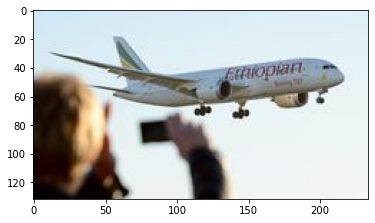

In [13]:
make_predictions('EthAir_Test.jpg')

array([[5.7013083]], dtype=float32)

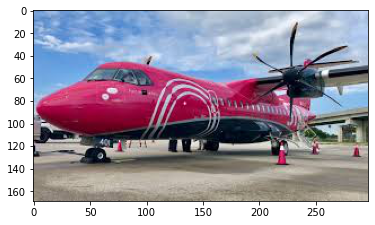

In [14]:
make_predictions('airplane_test.jpg')

array([[17.643923]], dtype=float32)

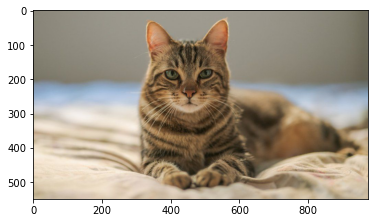

In [15]:
make_predictions('cat.jpg')

array([[57.437252]], dtype=float32)

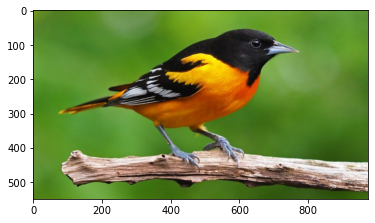

In [16]:
make_predictions('bird.jpg')

In [17]:
def EthiopianAir(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("Ethiopian Airlines plane")
    else:
        print("Something else")

Ethiopian Airlines plane


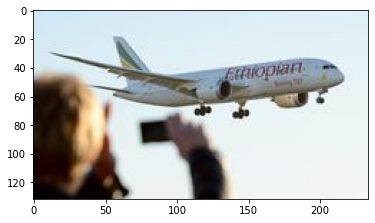

In [18]:
EthiopianAir('EthAir_Test.jpg')

Something else


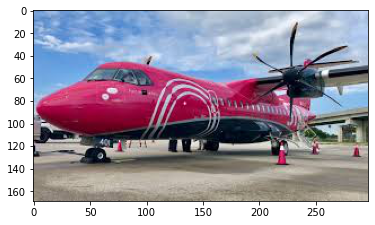

In [19]:
EthiopianAir('airplane_test.jpg')